# Tableau Data Science Challenge

- Data Science - Data Scientist
- Candidate: Ken Tsung-Chin Han 


# [Instructions]
1. Select a dataset from Kaggle using some or all of the following search terms: {risk, prediction, classifier}.  
2. Provide a concise statement of the question to be studied using this dataset. 
3. Analyze the dataset and provide a (partial) solution 
    - Use an interactive format such as a Jupyter notebook containing the solution, documentation, and discussion points. 
    - Plan to spend approximately 4 hours but no more than 6 hours on this assignment. 
    - The objective isn’t a complete solution; it’s possible that the result will be a negative one. The goal is to explain what you did, what else you would have/could have done, and what you learned. 
    - Inanimate references are perfectly acceptable.

Notes:
   1. You may use any Kaggle dataset, even one with a posted solution. However, we are looking for your own thoughts and ideas, so please don’t reproduce the exact question of one of the solutions.
   2. While you may use any dataset and methods you chose, please consider the kinds of questions and results that might be of interest to Tableau.
   3. Feel free to ask questions via email: kcrowe@tableau.com


# [Table of Contents]

- A - [Chosen Problem and Dataset](#1)
- B - [Enviroment & Setup](#2)
- C - [Data Initialization](#3)
- D - [Data Imputing and Processing](#4)
- E - [Exploratory Data Analysis (EDA)](#5)
- F - [Processing & Preparing Modeling Data](#6)
- G - [ML Methodology & Model pipeline](#7)
- H - [Prediction](#8)
- I - [Conclusions](#9)
- J - [Future Study & Directions](#10)


# A - Chosen Problem and Dataset<a class="anchor" id="1"></a>

### 1. Motivation
**To decide a dataset, I would like to find a problem that can demonstrates my knowledge and skills in twofolds:**

- (Data Science) Demonstrate my data science skills and knowledge in breadth as well as in depth.
- (Role & Business) To inline with the position's responsbilities, I would also like to showcase the potential probelms in terms of the development of Tableau's corporate data science strategy, such as develop DS solutions to increase and optimize customer experiences, targeting and business outcomes.

### 2. Problems 
**Context:**

A company has plans to enter new markets with the products (P1, P2, P3, P4 and P5). After intensive market research, they’ve deduced that the behavior of new market is similar to their existing market.

**Content & Objective:**

In their existing market, the product partner has classified all customers into 4 segments (A, B, C, D ). Then, they performed segmented outreach and communication for different segment of customers. This strategy has work exceptionally well for them. They plan to use the same strategy on new markets and have identified 2627 new potential customers.

The objective is to help the team to predict the right group of those new customers.

### 3. Data
- Train Dataset (Train.csv)
- Test Dataset (Test.csv)
- Sample Submissions Form (sample_submission.csv)
- Data Descriptions:

| Name                | Character                                                         |
| ---                 | ---                                                               |
| ID                  |  Unique ID                                                        |
| Gender              | Gender of the customer                                            |
| Ever_Married        | Marital status of the customer                                    |
| Age                 | Age of the customer                                               |
| Graduated           | Is the customer a graduate?                                       |
| Profession          | Profession of the customer                                        |
| Work_Experience     | Work Experience in years                                          |
| Spending_Score      | Spending score of the customer                                    |
| Family_Size         | Number of family members for the customer(including the customer) |
| Var_1               | Anonymized Category for the customer                              |
| Segmentation(target)| Customer Segment of the customer                                  |
 



# B - Enviroment & Setup<a class="anchor" id="2"></a>

### 1. Install & Load Packages

In [267]:
# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install miceforest
# !{sys.executable} -m pip install autoimpute
# !{sys.executable} -m pip install pandasql
# !{sys.executable} -m pip install graphviz

In [269]:
# data
import pandas as pd
import numpy as np
from pandasql import sqldf

# viz
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

# imputations
from autoimpute.imputations import SingleImputer, MultipleImputer, MiceImputer
from autoimpute.visuals import plot_md_percent
from autoimpute.visuals import plot_md_locations

# machine learning, cv, fine tuning
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc, recall_score,precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut 
import xgboost as xgb
from xgboost import plot_importance
from xgboost import plot_tree
from xgboost import XGBClassifier

# other
import csv
import gc

# plot inline and set style
%matplotlib inline
sns.set_style('darkgrid')

# mute warnings
import warnings
warnings.filterwarnings('ignore')

# set pd max rows & columns
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)

### 2. Helper Functions 

Basic Data Helper

In [244]:
def data_check_basic(df):
    """simple helper peform basic data check
        
    Args:
        df(array): dataframe.
    Returns:
        df(array): dataframe for head view and.
        print: print
    """
    print('<------- Dimension: -------> \n')
    print(df.shape) # dimensions
    print('\n<------- Unique values: -------> \n')
    print(df.nunique()) # unique values
    print('\n<------- Check dtype: -------> \n')
    print(df.info()) # check dtype
    print('\n<------- Check missing vlaues (count): -------> \n')
    print(df.isnull().sum()) # check nan count
    print('\n<------- Check missing vlaues (%): -------> \n')
    print(round(df.isnull().sum()/df_train.shape[0]*100, 2)) # check nan %
    print('\n<------- Quick look at data: -------> \n')
    
    return df.head()


EDA Helper

In [265]:
def plot_cat_feature_per_segment(df, feature):
    """helper to visulize categorical features for EDA
    
        Args:
            df(array): dataframe
        Returns:
            plot(): multi plots

    """
    print('\033[1m'+'Feature - {}:\n'.format(feature))
    print('\033[0m'+'Value Counts in the training dataset:\n')
    print(df_train_imputed[feature].value_counts())

    # counting feature in each segment
    ax1 = df_train_imputed.groupby(['Segmentation'])[feature].value_counts().unstack().round(2)

    # percentage of feature in each segment
    ax2 = df_train_imputed.pivot_table(columns=feature,\
                                       index='Segmentation', \
                                       values='ID',\
                                       aggfunc='count')
    ax2 = ax2.div(ax2.sum(axis=1), axis = 0).round(2)

    # plot1 - counting 
    fig, ax = plt.subplots(1,2)
    ax1.plot(kind="bar",ax = ax[0],figsize = (15,5))
    ax[0].set_xticklabels(labels = ['A','B','C','D'],rotation = 0)
    ax[0].set_title(str(ax1))

    # plot2 - stacked bars
    ax2.plot(kind="bar",stacked = True,ax = ax[1],figsize = (15,5))
    ax[1].set_xticklabels(labels = ['A','B','C','D'],rotation = 0)
    ax[1].set_title(str(ax2))
    plt.show()
    
    
def plot_num_feature_per_segment(df, feature):
    """helper to visulize numerical features for EDA
    
        Args:
            df(array): dataframe
        Returns:
            plot(): multi plots

    """
    # Looking the distribution of feature
    plt.figure(figsize=(12,8))
    skewness = round(df[feature].skew(),2)
    kurtosis = round(df[feature].kurtosis(),2)
    mean = round(np.mean(df[feature]),0)
    median = np.median(df[feature])
    
    # plot boxplot
    plt.subplot(1,2,1)
    sns.boxplot(y=df[feature])
    plt.title('Boxplot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean, median, skewness, kurtosis))
    
    # plot distributions
    plt.subplot(1,2,2)
    sns.distplot(df[feature])
    plt.title('Distribution Plot\n Mean:{}\n Median:{}\n Skewness:{}\n Kurtosis:{}'.format(mean, median, skewness, kurtosis))
    plt.show()

    # Looking the distribution of feature with respect to each segment
    plt.figure(figsize=(12,8))

    plt.subplot(1,2,1)
    sns.boxplot(data=df, x="Segmentation", y=feature)
    plt.title('Boxplot')

    plt.subplot(1,2,2)
    group_mean = []
    for i in ['A', 'B', 'C', 'D']:
        group_mean.append(df[df.Segmentation == i][feature].mean())
        sns.kdeplot(df[df.Segmentation == i][feature], shade=False, label=i)

    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.title("Mean\n A: {}\n B: {}\n C: {}\n D: {}".format(round(group_mean[0],0),\
                                                            round(group_mean[1],0),\
                                                            round(group_mean[2],0),\
                                                            round(group_mean[3],0)))

    plt.show()
    
    del group_mean

    

Encoding Helper

In [266]:
def ohe_features(df, feature):
    """Helper to perform one hot encoding for the categorical features
        Args:
            df(array): dataframe
        Returns:
            list(array): new generated columns names 
    """
    # one-hot encoding
    tmp = pd.get_dummies(df[feature], prefix=feature + '_')
    df = pd.merge(df, tmp, left_index=True, right_index=True)   
    df.drop([feature], axis=1, inplace=True)
    if tmp.columns is not None:
        print('Following ohe has been generated: {}'.format([col for col in tmp.columns]))
        print('\n')
        return df
    else:
        print('error, check!\n')
        
    del tmp


Model Pipelines

In [ ]:
def model_pipeline(df_features, df_y, n_split=5):
    """model pipeline for training

        Args:
            df_features(array): features set
            df_y(array): target variable

        Kwargs:
            n_split(int): k fold splitting parmeter for cross validations
            
        Returns:
            (plots): errors evaluations plots 
            (str): print 
    """
    # cv setup
    kf = KFold(n_splits=n_split) # define the split - into k folds 
    kf.get_n_splits(df_features) # returns the number of splitting iterations in the cross-validator
    KFold(n_splits=n_split, random_state=999, shuffle=True)

    for train_index, val_index in kf.split(df_features):
        # split train and dev set
        print("train:", train_index, "dev:", val_index)
        X_train, X_dev = df_features.iloc[train_index], df_features.iloc[val_index]
        y_train, y_dev = df_y.iloc[train_index], df_y.iloc[val_index]

       # implement xgboost algo
        model = XGBClassifier(
            objective='multi:softprob',
            num_class=4,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.9,
            colsample_bylevel=0.7,
            colsample_bytree=0.8,
            reg_alpha = 0.1,
            reg_lambda=0,
            nthread=8,
            random_state=999,
        )

        # fit the algo, with the error metric to be mlogloss
        model.fit(
            X_train, 
            y_train,
            eval_metric='mlogloss', 
            eval_set=[(X_train, y_train), (X_dev, y_dev)],
            verbose=20
#             early_stopping_rounds=30
        )

        # collect the prediction values from both train and dev set 
        X_train_pred = model.predict(X_train)
        X_dev_pred = model.predict(X_dev)
        
        # collect evaluation report:
        print('\nModel Report')
        print('Classification report: \n')
        print(classification_report(y_dev, X_dev_pred))
        print('Accuracy : %.4g' % accuracy_score(y_train, X_train_pred))
        print('Log Loss Score (Train): %f' % log_loss(y_train, model.predict_proba(X_train)))
        
        # retrieve performance metrics
        results = model.evals_result()
        epochs = len(results['validation_0']['mlogloss'])
        x_axis = range(0, epochs)
        
        # plot multiclassification log loss
        fig, ax = plt.subplots()
        ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
        ax.plot(x_axis, results['validation_1']['mlogloss'], label='Dev')
        ax.legend()
        plt.ylabel('Multiclass Logloss')
        plt.title('Model Multiclass Logloss')
        plt.show()
        
        # visualize feature importance
        print('\nNumber of times a feature is used to split the data across all trees:')
        plt.rcParams["figure.figsize"] = (10, 8)
        plot_importance(model)
        plt.show()

        print('\nNumber of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:')
        plt.rcParams["figure.figsize"] = (10, 8)
        plot_importance(model, importance_type='gain')
        plt.show()

        print('\nThe average training loss reduction gained when using a feature for splitting:')
        plt.rcParams["figure.figsize"] = (10, 8)
        plot_importance(model, importance_type='cover')
        plt.show()
        
        return model
        


# C - Data Initialization<a class="anchor" id="3"></a>

### 1. Load Train and Test Data

In [5]:
df_train = pd.read_csv('./data/Train.csv') # exisiting customers data with label 'segmentation'
df_test = pd.read_csv('./data/Test.csv') # new customers data
print('train data diemnsion: ', df_train.shape)
print('test data diemnsion: ', df_test.shape)


train data diemnsion:  (8068, 11)
test data diemnsion:  (2627, 10)


Check if train and test data features are inline.

In [6]:
# check if there are additional features columns in test data
addtional_col = []
for col in df_test.columns:
    if col not in df_train.columns:
        addtional_col.append(col)
if len(addtional_col) != 0:
    print('Additional column(s) in test data: ', addtional_col)
else:
    print('In the test data, all the features columns are in line with train data')
    

In the test data, all the features columns are in line with train data


We know the data features are the same from both train and test data. Train dataset has the label "Segmentation". The "Segmentation" is our target variable to predict in this study.

Let us have an overview of the train and test data.

In [8]:
# check train data
data_check_basic(df_train)

<------- Dimension: -------> 

(8068, 11)

<------- Unique values: -------> 

ID                 8068
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          4
dtype: int64

<------- Check dtype: -------> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float6

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [9]:
# check test data
data_check_basic(df_test)


<------- Dimension: -------> 

(2627, 10)

<------- Unique values: -------> 

ID                 2627
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
dtype: int64

<------- Check dtype: -------> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               2627 non-null   int64  
 1   Gender           2627 non-null   object 
 2   Ever_Married     2577 non-null   object 
 3   Age              2627 non-null   int64  
 4   Graduated        2603 non-null   object 
 5   Profession       2589 non-null   object 
 6   Work_Experience  2358 non-null   float64
 7   Spending_Score   2627 non-null   object 
 8   Family_Size      2514 non-null   float64
 9   Var_1            

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,458989,Female,Yes,36,Yes,Engineer,0.0,Low,1.0,Cat_6
1,458994,Male,Yes,37,Yes,Healthcare,8.0,Average,4.0,Cat_6
2,458996,Female,Yes,69,No,NaN,0.0,Low,1.0,Cat_6
3,459000,Male,Yes,59,No,Executive,11.0,High,2.0,Cat_6
4,459001,Female,No,19,No,Marketing,NaN,Low,4.0,Cat_6


 
1. From the overivew of the data, we also understand that the data involves different data types, including numerical and categorical inputs (binary and enum types).
 
2. There are missing values in both train and test data. In the data processing section, to be meaningful, we will deal with the imputation problems before conducting the Exploratory Data Analysis and Modeling.

At the moment, let us construct the full dataset by combining the train and test data. 


In [10]:
# indicator for training data
obs_train = df_train.shape[0]
print('Indicator number to show the last row for the traning set: ', obs_train)

# merge the train and test data to construct the final modeling data
# note that test data is not used for training and validation purpose. 
# validation set will be drawn from train dataset
df_test['Segmentation'] = 'To_Be_Predicted_do_not_use'
modeling = pd.concat([df_train, df_test], sort=False).reset_index(drop=True)


Indicator number to show the last row for the traning set:  8068


In [11]:
data_check_basic(modeling)


<------- Dimension: -------> 

(10695, 11)

<------- Unique values: -------> 

ID                 8363
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      15
Spending_Score        3
Family_Size           9
Var_1                 7
Segmentation          5
dtype: int64

<------- Check dtype: -------> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10505 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10593 non-null  object 
 5   Profession       10533 non-null  object 
 6   Work_Experience  9597 non-null   float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10247 non-null  flo

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


# D - Data Imputing and Processing<a class="anchor" id="4"></a>

**In our study, for this types of problems and dataset in Supvervised Learning and Classification, we expect more clean and complete dataset. As such, how to handle  missing data is important before conducting analysis and feeding in ML algorithm.**

From our previous section, we understand that we have multiple missing data involves both numeric and categorical data types. The categorical data can be broken down by binary and enum types.  

In order to better handle variables of varing types and complexities, I here levarge the MICE (Multivariate imputation by chained equations) imputation methods, as opposed to single imputations. In stead of just replacing the missing values with basic statistics in a single feature, imputing under the hood of MICE is beneficial, because MICE operates under the assumption that given the variables used in the imputation procedure, the missing data are **missing at random**, which means that the probability that a value is missing depends only on observed values and not on unobserved values. In other words, after controlling for all of the available data, any remaining missingness is completely random. **This practice can make sure imputing is unbiased estimates.** 

**In my imputing strategy, depending on the types and senses of the data, I implement different model-based strategy.**

- For the features of 'Ever_Married' and 'Graduated', I utilized the bayesian binary logistic imputer for the binary types.

- For the features of 'Profession' and 'Var_1', I leveraged the multinomial logistic imputer for the categorical enum types. 

- For the features of 'Work_Experience' and 'Family_Size', I used the predictive mean matching imputer for the numerical types. 

**Following shows the imputation procedure:**


### 1.Data Imputations & Strategies

In [56]:
modeling2 = modeling.copy()

Firstly, let us visualize the missing values:

- Count missing values by features
- Check the missing values positions for each features


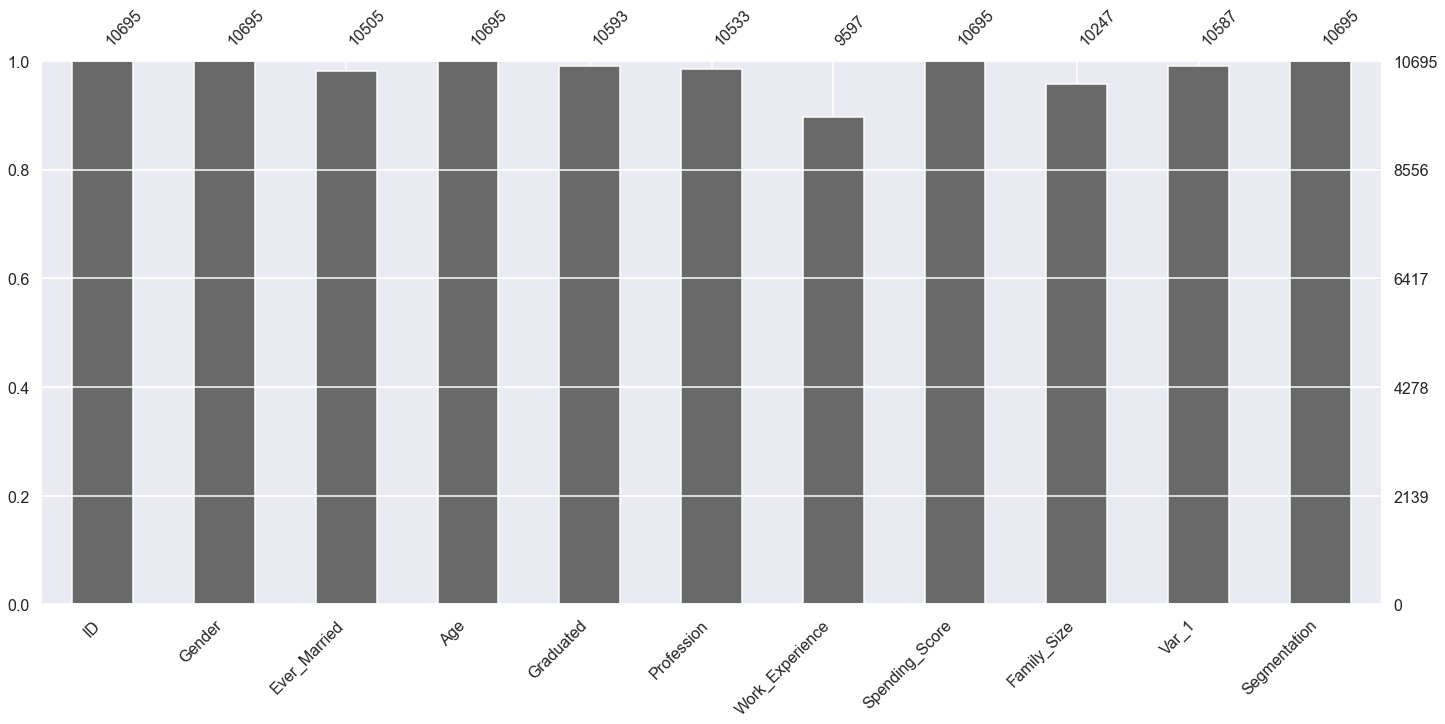

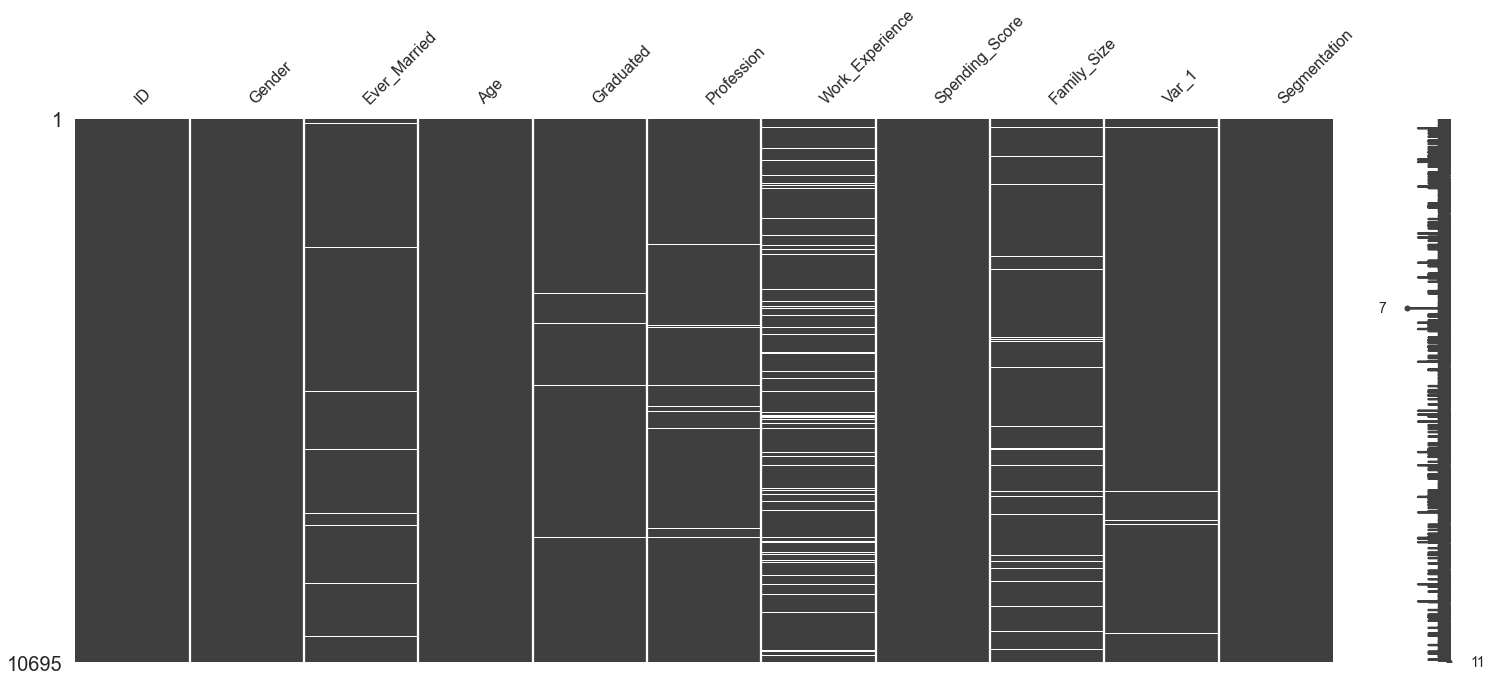

In [59]:
plot_md_percent(modeling2)
plot_md_locations(modeling2)

We can see that work experience feature appeards to have more missing values in both train and test dataset.

Now, let's implement the mice imputation proceduce as described:


In [65]:
# create a complex instance of the MiceImputer
# specify strategies by column and predictors for each column
# we return a list of the results, because we need to do this all at once

mice = MultipleImputer(
    n = 1,\
    strategy = {
        'Ever_Married': 'bayesian binary logistic',
        'Graduated': 'bayesian binary logistic',
        'Profession': 'multinomial logistic',
        'Work_Experience': 'pmm',
        'Family_Size': 'pmm',
        'Var_1': 'multinomial logistic'
        
    },\
    predictors = {
        'Ever_Married': ['Gender', 'Age','Spending_Score', 'Segmentation'],
        'Graduated': ['Gender', 'Age','Spending_Score', 'Segmentation'],
        'Profession': ['Gender', 'Age','Spending_Score', 'Segmentation'],
        'Work_Experience': ['Gender', 'Age','Spending_Score', 'Segmentation'],
        'Family_Size': ['Gender', 'Age','Spending_Score', 'Segmentation'],
        'Var_1': ['Gender', 'Age','Spending_Score', 'Segmentation']
        
    },\
    imp_kwgs = {
        'pmm': {'neighbors': 10,
                'fill_value': 'mean'
               }
    },\
    return_list=True

)

modeling_imputed = mice.fit_transform(modeling2)


/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fit_intercept=True, normalize=False, copy_X=True, n_jobs=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fit_intercept=True, normalize=False, copy_X=True, n_jobs=None as keyword args. From version 1.0 (renaming of 0.25) passing these as positional argume

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2342 seconds.
/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 249 seconds.
/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 176 seconds.
/Users/tsung-chin.han/ZDOC/Interview_2021_great/Tableau/customer_expectation/venv/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 168 seconds.
The acceptance probability does not match the target. It is 0.8819134154075768, but should be close to 0.8. Try to increase the number of tuning steps.


**Let's check the before and after imputations**

In [73]:
print('\033[1m'+'Before Imputations:\n')
pd.DataFrame(df_train.isnull().sum(), columns=["records missing"]).T


Before Imputations:



,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
records missing,0,0,140,0,78,124,829,0,335,76,0


In [72]:
print('\033[1m'+'After Imputations:\n')
pd.DataFrame(modeling_imputed[0][1].isnull().sum(), columns=["records missing"]).T


After Imputations:



,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
records missing,0,0,0,0,0,0,0,0,0,0,0


### 2. Save a copy of the full imputed dataset

let's save a copyt of the full imputed dataset, as running the imputation procedure is time consuming


In [78]:
# modeling_imputed_complete = modeling_imputed[0][1].copy()
# modeling_imputed_complete.to_csv('./data/modeling_imputed_complete.csv', index=False)

So, we can confirm we impute the missing values based on the imputation strategy.

# E - Exploratory Data Analysis (EDA)<a class="anchor" id="5"></a>

At this moment, our data is clean and complete, let's re-check the full dataset.

In [82]:
data_check_basic(modeling_imputed_complete)

<------- Dimension: -------> 

(10695, 11)

<------- Unique values: -------> 

ID                 8363
Gender                2
Ever_Married          2
Age                  67
Graduated             2
Profession            9
Work_Experience      71
Spending_Score        3
Family_Size          44
Var_1                 7
Segmentation          5
dtype: int64

<------- Check dtype: -------> 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10695 entries, 0 to 10694
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               10695 non-null  int64  
 1   Gender           10695 non-null  object 
 2   Ever_Married     10695 non-null  object 
 3   Age              10695 non-null  int64  
 4   Graduated        10695 non-null  object 
 5   Profession       10695 non-null  object 
 6   Work_Experience  10695 non-null  float64
 7   Spending_Score   10695 non-null  object 
 8   Family_Size      10695 non-null  flo

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,4.1,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,3.0,High,6.0,Cat_6,A


**Now, for the training purpose, we should only focus on our training data. We should understand that test data should be set aside for prediction purpose only. Validation set is derived from train data.**

In [83]:
# Refer to imputed train data
df_train_imputed = modeling_imputed_complete[:obs_train] # imputed training data

### 1. Target Variable (Segmentations)

we transform the Segmentations and look at the distribution from the customers.

  Segmentation  count
0            A   1972
1            B   1858
2            C   1970
3            D   2268


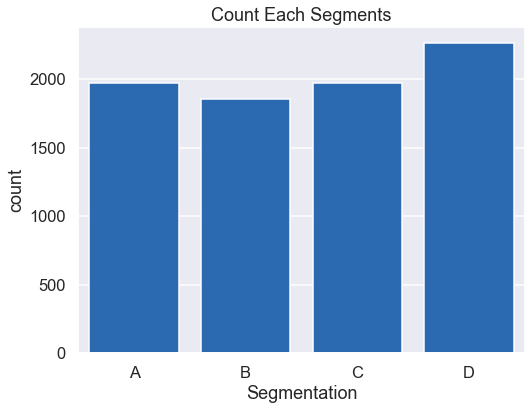

In [92]:
# data transform and visualize
tmp = df_train_imputed.copy()
tmp = sqldf("""
select
    segmentation,
    count(segmentation) as count
from tmp
group by 1

""")
print(tmp)
plt.figure(figsize=(8,6))
sns.barplot(x='Segmentation' , y='count', data=tmp, color='#1569C7').set_title('Count Each Segments')
del tmp


We can see that there are more customer being classified to segments D. The number of customer in segments A, B, and C are more or less evenly distributed.


### 2. Features - Univariate Analysis

### Gender


Feature - Gender:

Value Counts in the training dataset:

Male      4417
Female    3651
Name: Gender, dtype: int64


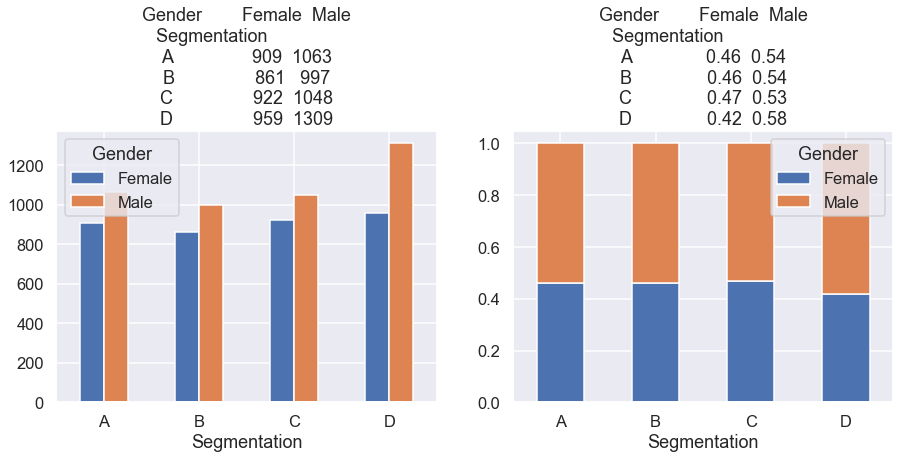

In [95]:
plot_cat_feature_per_segment(df_train_imputed, feature='Gender')

We can see all the 4 segments have around the same number of male-female distributions. In all segment male are more than female. Interestingly, segment D has highest male percentage, compared to other segments.


### Ever_Married

Feature - Ever_Married:

Value Counts in the training dataset:

Yes    4730
No     3338
Name: Ever_Married, dtype: int64


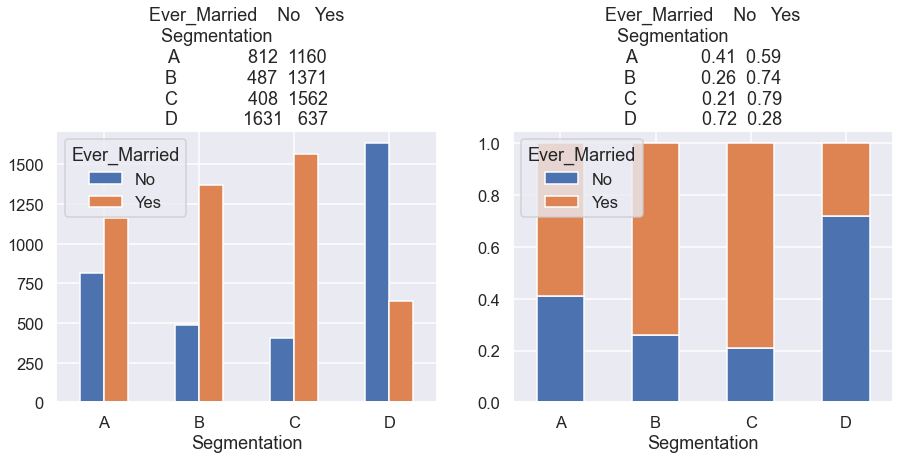

In [96]:
plot_cat_feature_per_segment(df_train_imputed, feature='Ever_Married')

We know that most of the customers in segment C are married while segment D has least number of married customers. It shows that segment D is a group of customers that are singles and maybe younger in age.


### Age

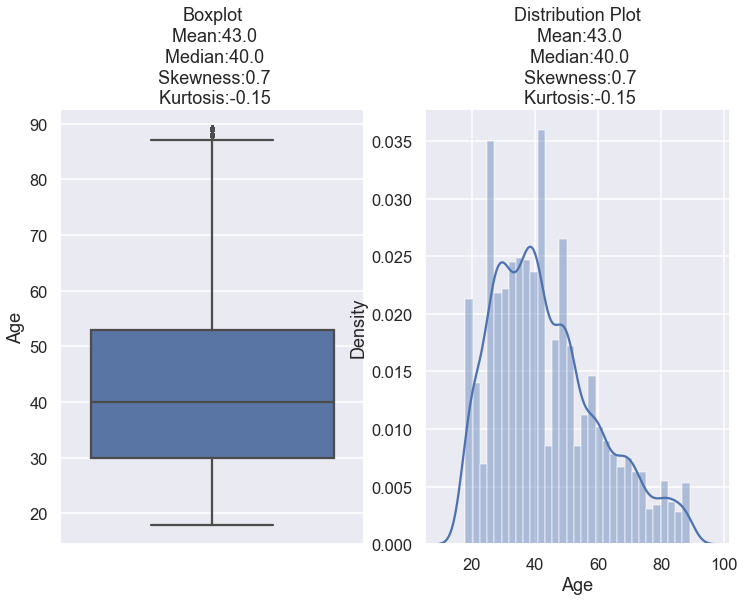

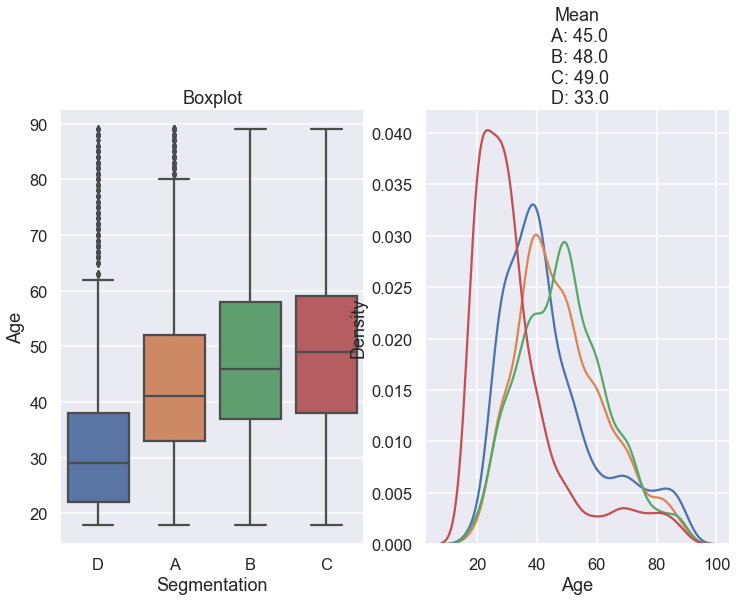

In [103]:
plot_num_feature_per_segment(df_train_imputed, feature= 'Age')

We notice that the mean age of segment D is 33 and that people in this segment are belong to 30s., They are younger and also from 'Ever_Married' distribution, it is seen that segment D has maximum number of customers who are singles indicating they are younger. 

In addition, segment C has mean age of 49 and we also seen that most cutomers in this segment are married.

If we group the age in buckets and evaluate, it's much clear to show the distributions. As shown in below:


In [104]:
df_train_imputed.Age.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    8068.000000
mean       43.466906
std        16.711696
min        18.000000
25%        30.000000
50%        40.000000
75%        53.000000
90%        69.000000
95%        77.000000
99%        87.000000
max        89.000000
Name: Age, dtype: float64

In [105]:
# divide customers in the 4 age buckets
df_train_imputed['Age_Bin'] = pd.cut(df_train_imputed.Age,\
                                     bins=[17,30,45,60,90],\
                                     labels=['30-','31-45','46-60','60+']
                                    )


Feature - Age_Bin:

Value Counts in the training dataset:

31-45    2840
30-      2026
46-60    1865
60+      1337
Name: Age_Bin, dtype: int64


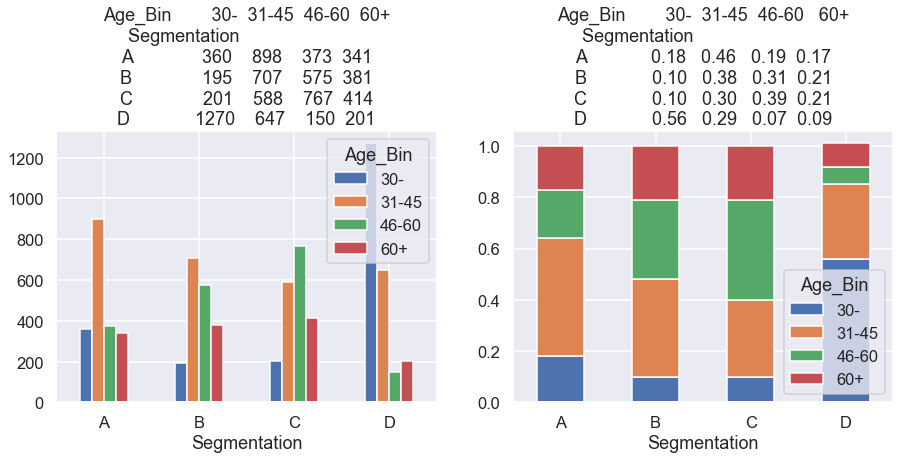

In [106]:
plot_cat_feature_per_segment(df_train_imputed, feature='Age_Bin')

### Graduated

Feature - Graduated:

Value Counts in the training dataset:

Yes    5025
No     3043
Name: Graduated, dtype: int64


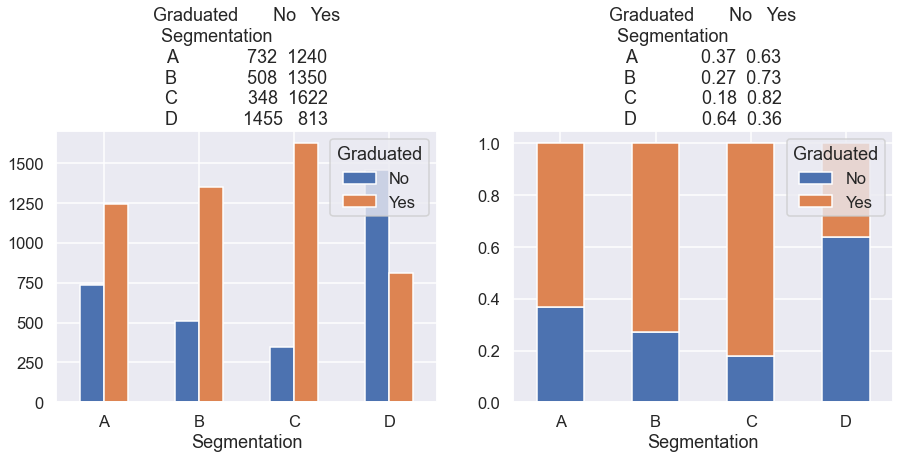

In [107]:
plot_cat_feature_per_segment(df_train_imputed, feature='Graduated')

In terms of graduation or not, Segment C has most number of customers who are graduated while segment D has lowest number of graduate customers.


### Profession

Feature - Profession:

Value Counts in the training dataset:

Artist           2578
Healthcare       1365
Entertainment     956
Engineer          707
Doctor            688
Lawyer            632
Executive         604
Marketing         292
Homemaker         246
Name: Profession, dtype: int64


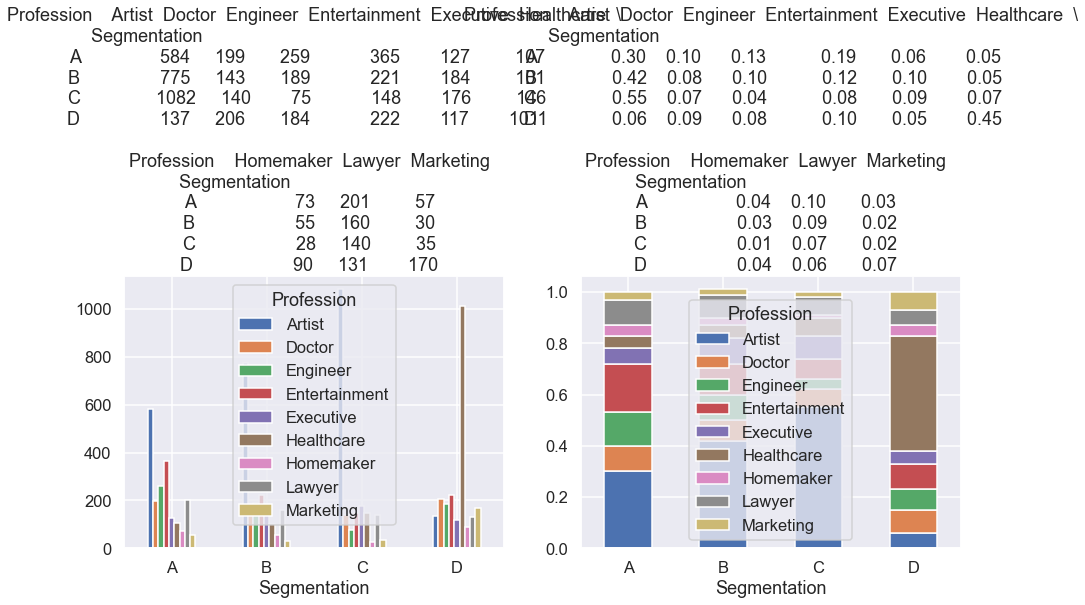

In [108]:
plot_cat_feature_per_segment(df_train_imputed, feature='Profession')

Interestly, Segment A, B and C have major customers from profession **Artist**, while Segment D have major customers from profession **Healthcare**. Also, **Homemaker** is least in all the four segment.


### Work_Experience

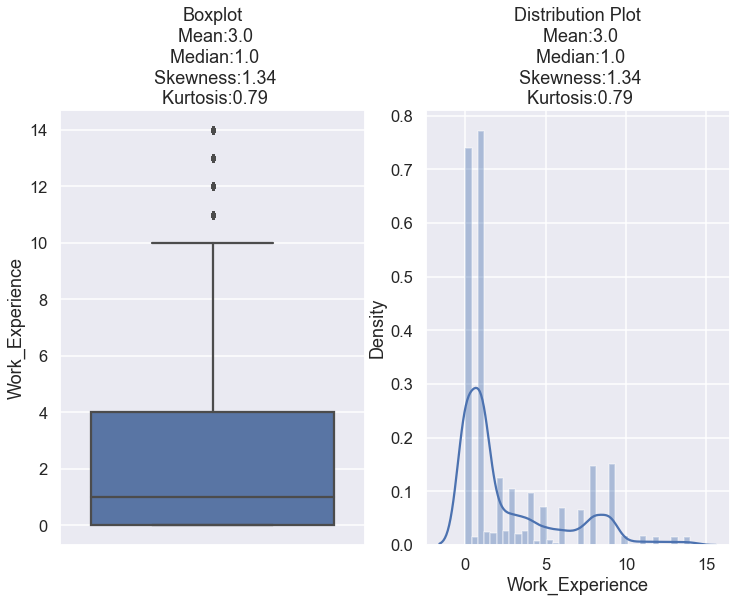

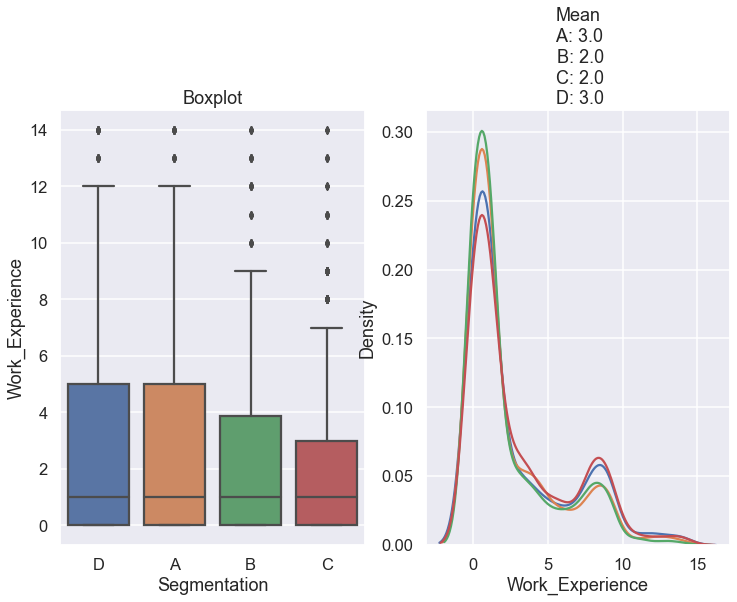

In [109]:
plot_num_feature_per_segment(df_train_imputed, feature= 'Work_Experience')

We can understand that segment D has customers with relatively more experienced than other segments, whereas segment C has customers with lower experience.

Again, we are able to see clearer distributions regarding the work experience in segments by bucketing them. As shown in below:


In [110]:
df_train_imputed.Work_Experience.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    8068.000000
mean        2.646852
std         3.257352
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
90%         8.000000
95%         9.000000
99%        13.000000
max        14.000000
Name: Work_Experience, dtype: float64

In [111]:
# dividing customers into 3 category of work experiences 
df_train_imputed['Work_Exp_Category'] = pd.cut(df_train_imputed.Work_Experience,\
                                               bins=[-1, 1, 7, 15],\
                                               labels=['Low Experience','Medium Experience','High Experience']
                                              )


Feature - Work_Exp_Category:

Value Counts in the training dataset:

Low Experience       4774
Medium Experience    2112
High Experience      1182
Name: Work_Exp_Category, dtype: int64


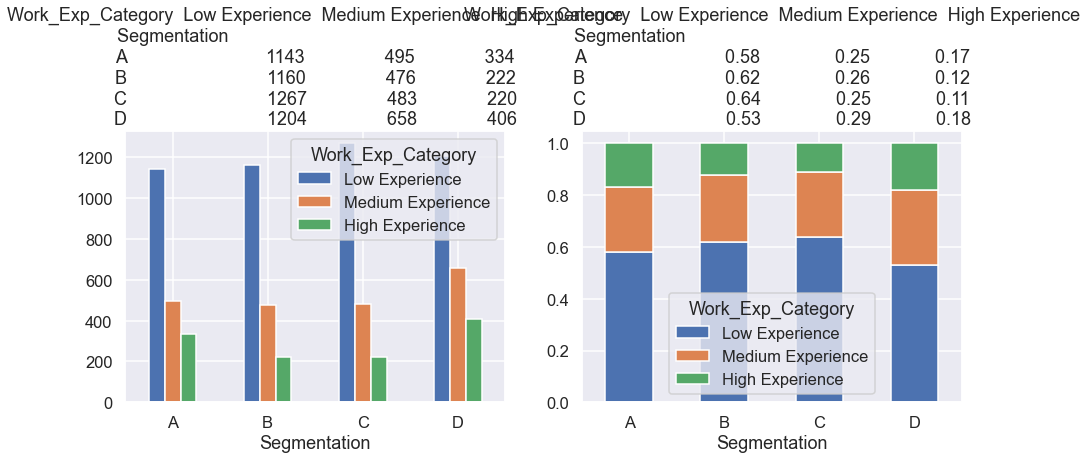

In [112]:
plot_cat_feature_per_segment(df_train_imputed, feature= 'Work_Exp_Category')

### Spending_Score

Feature - Spending_Score:

Value Counts in the training dataset:

Low        4878
Average    1974
High       1216
Name: Spending_Score, dtype: int64


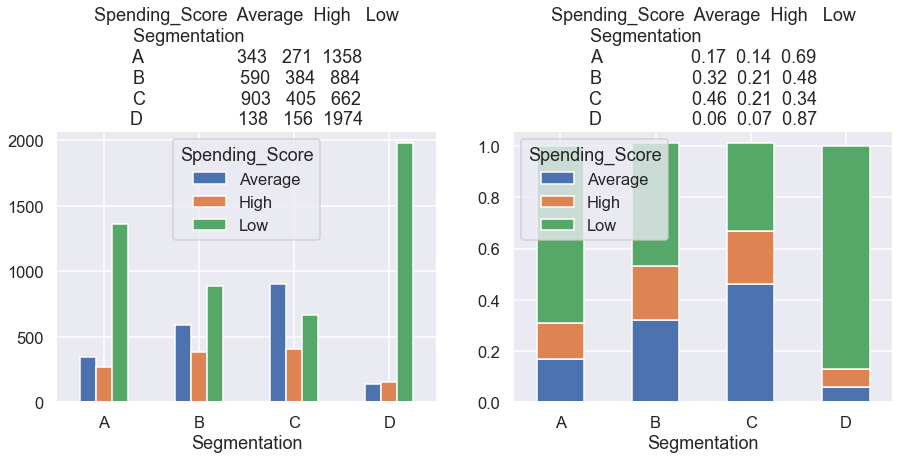

In [113]:
plot_cat_feature_per_segment(df_train_imputed, feature= 'Spending_Score')

Segment D, again, has the maximum number of people with low spending score, whereas in segment C, the average spending customers are more.


### Family_Size


Family size features is more spread, we treat this as a category for EDA, and it's easier to visualize by buckeing as well. As shown below:

In [117]:
df_train_imputed.Family_Size.describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99])

count    8068.000000
mean        2.843369
std         1.512276
min         1.000000
25%         2.000000
50%         2.800000
75%         4.000000
90%         5.000000
95%         5.800000
99%         8.000000
max         9.000000
Name: Family_Size, dtype: float64

In [118]:
# divide family size into 3 category
df_train_imputed['Family_Size_Category'] = pd.cut(df_train_imputed.Family_Size,\
                                                  bins=[0, 4, 6, 10],\
                                                  labels=['Small Family', 'Big Family', 'Joint Family']
                                                 )


Feature - Family_Size_Category:

Value Counts in the training dataset:

Small Family    7034
Big Family       844
Joint Family     190
Name: Family_Size_Category, dtype: int64


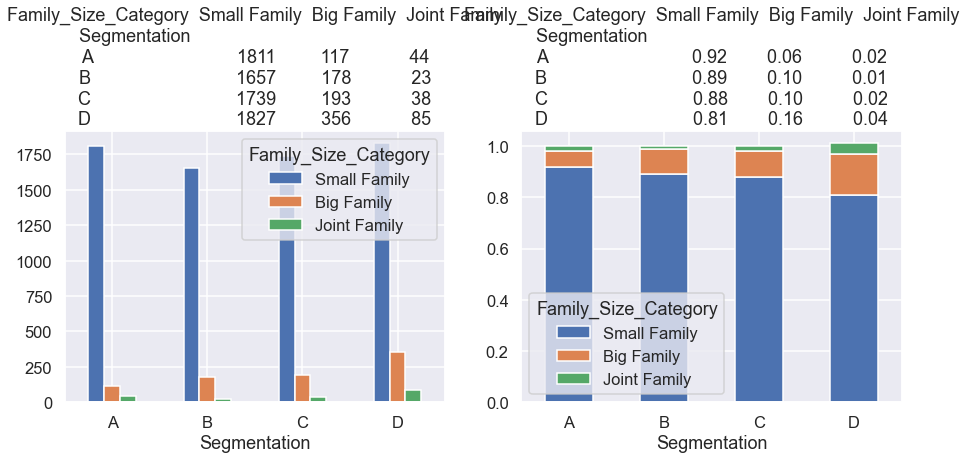

In [119]:
plot_cat_feature_per_segment(df_train_imputed, feature= 'Family_Size_Category')

Very interesting. From our data, we can see that most of the customers have family size of 1 or 2, meaning they have small family. However, segment D has more number of big families as opposed to other segments.


### Var_1

Feature - Var_1:

Value Counts in the training dataset:

Cat_6    5314
Cat_4    1089
Cat_3     822
Cat_2     422
Cat_7     203
Cat_1     133
Cat_5      85
Name: Var_1, dtype: int64


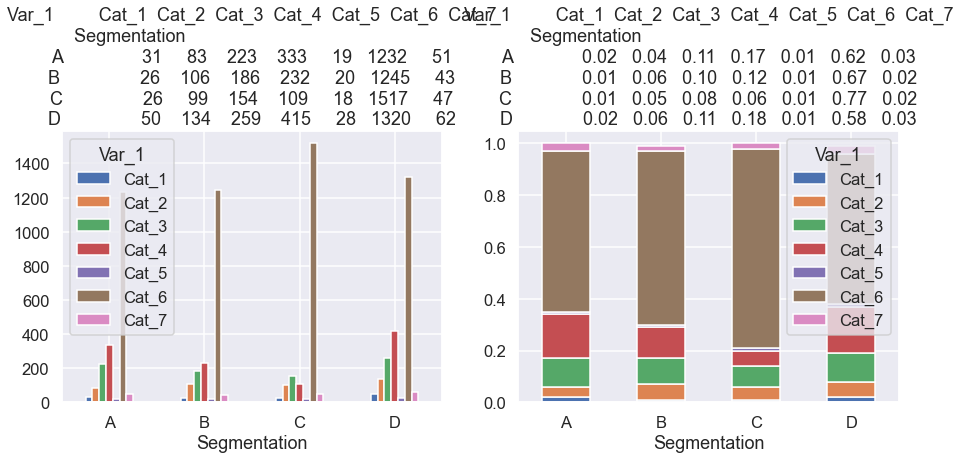

In [120]:
plot_cat_feature_per_segment(df_train_imputed, feature= 'Var_1')

For the Anonymized Category for the customer, we see that in each of the segment, the count of cat_6 or proportion of cat_6 is very high. That being said, most of the entries in the given data belongs to cat_6.


In [122]:
# df_train_imputed = df_train_imputed.drop(['Age_Bin', 'Work_Exp_Category', 'Family_Size_Category'], axis=1)

### 3 - Features corr

Let's check the features' 'linear' correlations by visualization.

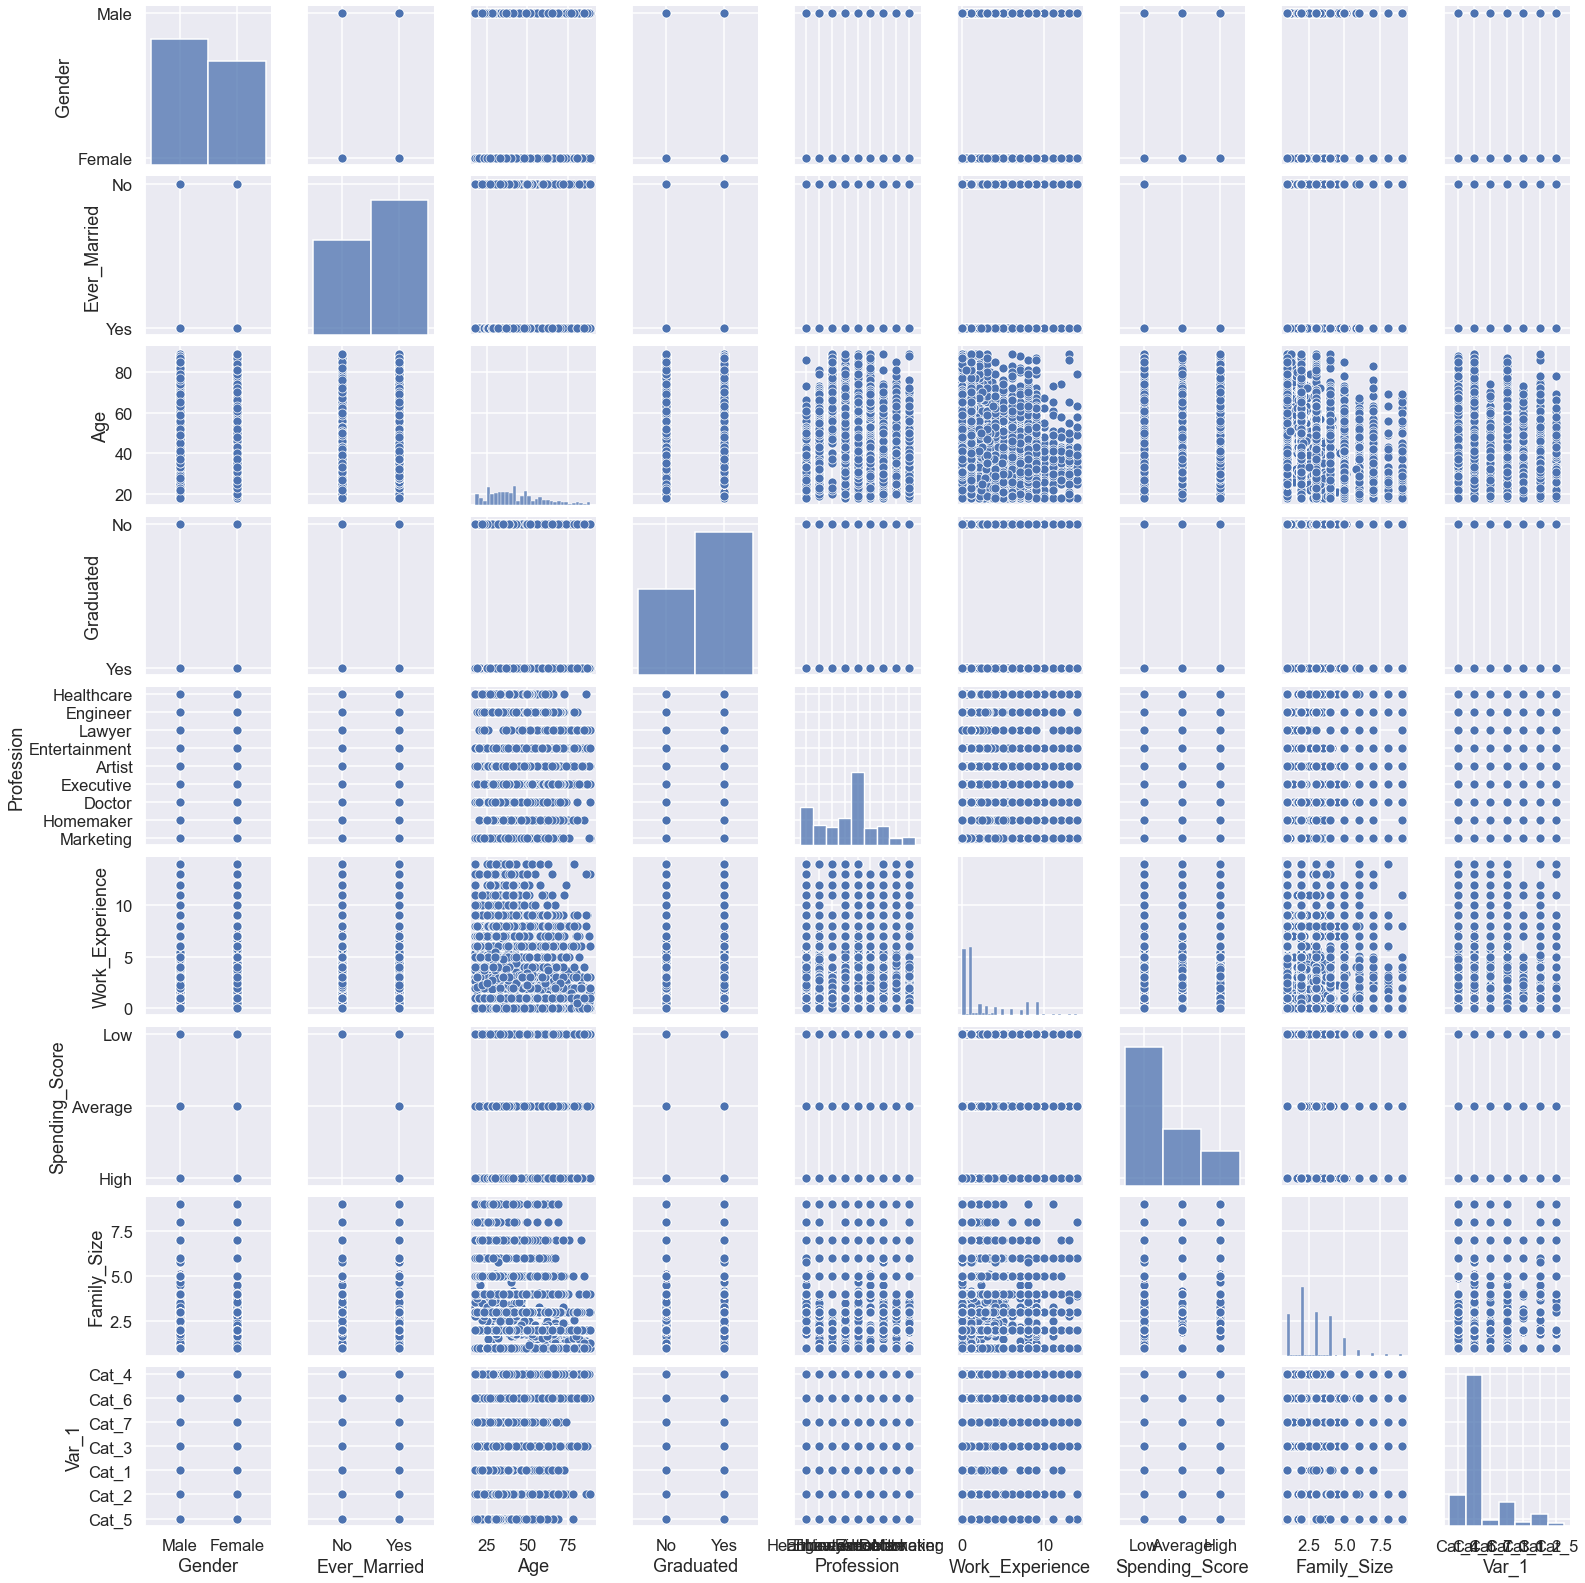

In [125]:
sns.pairplot(df_train_imputed,\
             vars=[
                    'Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
                    'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1'
                  ],\
             diag_kind="hist"
            )


As a result, the features do not share much linear relationship to each others. 

# F - Processing & Preparing Modeling Data<a class="anchor" id="6"></a>

### 1. Prepare final modeling dataset

In [148]:
modeling3 = modeling_imputed_complete.copy()

In [149]:
# get rid of customer id
modeling3.drop(['ID'], axis=1, inplace=True)

train_final = modeling3[:obs_train]
test_final = modeling3[obs_train:]
print('modeling train data shape: ', train_final.shape)
print('modeling test data shape: ', test_final.shape)

modeling train data shape:  (8068, 10)
modeling test data shape:  (2627, 10)


### 2. Feature Engineering

After assessing the exiting features, it's not very beneficial to extract meaninful features from the given dataset. Mainly becuase the features is already at its granular level and may not produce extrat signals if dividing further. **Unless we have other dataset to combine based on customer ID, otherwise in this study, we will not perform more feature extraction.** Rather, enoconding should be more important to our given dataset. 

For the target variable (Segmentations), we will encode the label with number to make sure machine readble. However, after the modeling, we will map the predicted label back to the original label.


### 3. Encoding

For our categorical features, in order to make it learnable from the Machine Learning classification algorithm and make senses, we will conduct **one-hot encoding**. This is to make sure we transform the categorical features to numerical feature without loosing its meanning and be complianced.


**For binary features:**

In [150]:
# encoding for binary variables
modeling3['Gender'] = modeling3['Gender']\
                        .apply(lambda x: 1 if x == 'Male' else 0)

modeling3['Ever_Married'] = modeling3['Ever_Married']\
                            .apply(lambda x: 1 if x == 'Yes' else 0)

modeling3['Graduated'] = modeling3['Graduated']\
                            .apply(lambda x: 1 if x == 'Yes' else 0)


**For enum types cateogorical features:**

In [152]:
# encoding for categorical variables by one-hot encoding
modeling3 = ohe_features(modeling3, feature='Profession')
modeling3 = ohe_features(modeling3, feature='Spending_Score')
modeling3 = ohe_features(modeling3, feature='Var_1')

print('Final modeling dataset features:\n')
print(modeling3.columns)

Following ohe has been generated: ['Profession__Artist', 'Profession__Doctor', 'Profession__Engineer', 'Profession__Entertainment', 'Profession__Executive', 'Profession__Healthcare', 'Profession__Homemaker', 'Profession__Lawyer', 'Profession__Marketing']


Following ohe has been generated: ['Spending_Score__Average', 'Spending_Score__High', 'Spending_Score__Low']


Following ohe has been generated: ['Var_1__Cat_1', 'Var_1__Cat_2', 'Var_1__Cat_3', 'Var_1__Cat_4', 'Var_1__Cat_5', 'Var_1__Cat_6', 'Var_1__Cat_7']


Final modeling dataset features:

Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Work_Experience',
       'Family_Size', 'Segmentation', 'Profession__Artist',
       'Profession__Doctor', 'Profession__Engineer',
       'Profession__Entertainment', 'Profession__Executive',
       'Profession__Healthcare', 'Profession__Homemaker', 'Profession__Lawyer',
       'Profession__Marketing', 'Spending_Score__Average',
       'Spending_Score__High', 'Spending_Score__Low', 'Var_1__Ca

**For our target variable (Segmentations):**

In [153]:
# create a dictionary lookup for further mapping
target_encoding_lookup = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'To_Be_Predicted_do_not_use': -1}
target_encoding_lookup

{'A': 1, 'B': 2, 'C': 3, 'D': 4, 'To_Be_Predicted_do_not_use': -1}

In [154]:
# encode target variable for ML algo purpose
modeling3['Segmentation'] = modeling3['Segmentation']\
                            .apply(lambda x: target_encoding_lookup[x])


In [155]:
# check the values
modeling3['Segmentation'].value_counts()

-1    2627
 4    2268
 1    1972
 3    1970
 2    1858
Name: Segmentation, dtype: int64

### 4. Splitting target, train features, and test features

In [156]:
# Seperate the target variable (y) and input features
# keep only the train data for target variable (y)
y = modeling3['Segmentation'][:obs_train]
modeling3.drop(['Segmentation'], axis=1, inplace=True)

# take a quick look and compliance check
print('target variable shape for train + test: ', y.shape)
print('input variable shape for train + test: ', modeling3.shape)
print('input variable shape for train: ', modeling3[:obs_train].shape)
print('input variable shape for test: ', modeling3[obs_train:].shape)

target variable shape for train + test:  (8068,)
input variable shape for train + test:  (10695, 25)
input variable shape for train:  (8068, 25)
input variable shape for test:  (2627, 25)


**Now, since we have done further processing for our modeling data and that's ready for ML algorithm. We should furhter extend our previous linear corrleation check and re-revalute the relationships by Spearman's coefficient for the following reasons:**

- we want to assess further for the monotonic relationship between each features.
- Due to the underlying distribution is not normal, we should assess it by rank orders.
- Spearman's coefficient is appropriate to be applied in categorical data, which explained in our dataset.


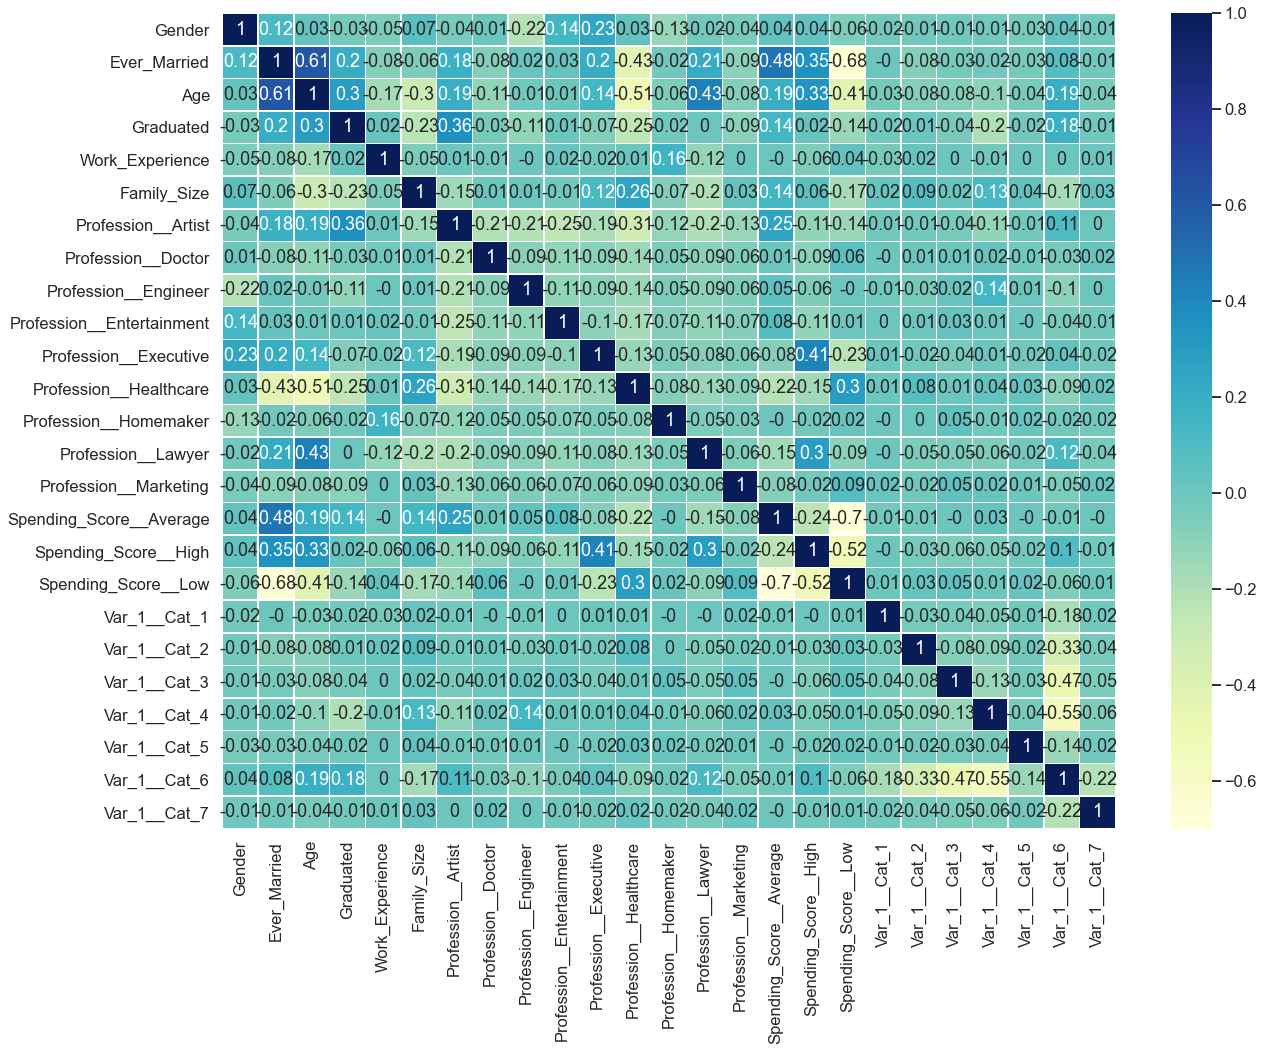

In [159]:
# correlation matrix with spearman coeff
plt.figure(figsize=(20,15))
sns.heatmap(modeling3[:obs_train].corr(method='spearman').round(2),linewidth = 0.5,annot=True,cmap="YlGnBu")
plt.show()

**We notice that the realtionships between Age, Ever_Married, and Spending are evident, such as**

- Age and Ever_Married has a positive correlation of 0.6, meaning customers who are married have more age, compared to those who are unmarried.

- Age and Spending_Score features has a positive correlation aorund 0.19 - 0.41, which means as age increase, the spending power somewhat increase.

- Age and Profession_Lawyer has a positive correlation of 0.42, meaning all those customers whose profession is lawyer are older in age to those of other professions people.

- Profession_Healthcare and Ever_Married has negative correlation of 0.43 which means all those peoples whose profession is healthcare are unmarried.(only 13% of healthcare professionals are married).

- Ever_Married and Spending_Average has a positive correlation aorund 0.5, which means those who are married spend averagely. Ever_Married and Spending_Low alos has a stonger positive correlation aorund 0.68, whereas Ever_Married and Spending_low has little positive correlation aorund 0.35.

- Profession_Executives and Spending_High has positive correlation of 0.41, meaning all those customer whose profession is executive spent high.(around 66% of executives spent high).




# G - ML Methodology & Model pipeline<a class="anchor" id="7"></a>

### 1. Methodology - Baseline

#### **a. Behind the decision**:

Firslty, as discussed earlier, **our objective of the problem is to solve customer segmentation problem given the data. The fact that we already have 4 labels(Segments) in our training data, that means, this is a supvervised multi-class classificaiton learing problem.**

To propose our baseline model, I choose a tree based ensemble learner (xgboost) as our classifier to implement. We should, however, extend or improved further from the baseline and form a stronger classifier in higher accuracy and understand how the errors appeared in each segments and then enhanced from there, but due to the time and context constraints, I implement one, a relatively stronger enough baseline to solve our problem. 

**The purpose is to demonstrate the proceduce that I started from a baseline model and understand the Data Science workflow for further improvement.**

The reason I chose xgboost as the baseline is that it is relavtively good classifer, which can handel multiple feaures, prevent overfitting with regularization, able to customize the underlying weak learner, and easier way to evaluate the perfomrance. At the end of the day, we need to sovle the probelm!


#### **b. Short Intro - ensemble learing and gradient boosting**:

Gradient boosting produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. It builds the model in a stage-wise fashion like other boosting methods do, and it generalizes them by allowing optimization of a differentiable loss function.

Like other boosting methods, gradient boosting combines weak learners into a single strong learner in an iterative fashion. It is easiest to explain in the least-squares regression setting, where the goal is to teach a model $F$ to predict values of the form $\hat{y}=F(x)$ by minimizing the mean squared error $\tfrac {1}{n}\sum _{i}({\hat {y}}_{i}-y_{i})^{2}$, where i indexes over some training set of size n of actual values of the output variable y.

The gradient boosting algorithm improves on $F_{m}$ by constructing a new model that adds an estimator h to provide a better model: $F_{m+1}(x)=F_{m}(x)+h(x)$. 

To find h, the gradient boosting solution starts with the observation that a perfect h would imply

$F_{m+1}(x)=F_{m}(x)+h(x)=y$

Therefore, gradient boosting will fit h to the residual $y-F_{m}(x)$. As in other boosting variants, each $F_{m+1}$ attempts to correct the errors of its predecessor $F_{m}$. A generalization of this idea to loss functions other than squared error, and to classification and ranking problems, follows from the observation that residuals $y-F(x)$ for a given model are the negative gradients (with respect to $F(x)$ of the squared error loss function $\frac {1}{2}(y-F(x))^{2}$.

**In my implementation, the xgboost is the extrem gradient boosting, where the gradient part is furhter enhanced for a better generalization ability as well as machine efficiency.** As shown below the pipeline implementation:

**Noticed that I applied the k fold cross validation procedure to better assess the training and testing errors per se.**


### 2. Model Pipeline

In [163]:
# get ready for xgboost model pipeline
xgb_train = modeling3[:obs_train]
xgb_test = modeling3[obs_train:]

print('seperate indicator: ', obs_train)
print('learning train set shape: ', xgb_train.shape)
print('learning test set shape: ', xgb_test.shape)
print('total observations: ', xgb_train.shape[0]+xgb_test.shape[0])

seperate indicator:  8068
learning train set shape:  (8068, 25)
learning test set shape:  (2627, 25)
total observations:  10695


**Again, we set aside our test data for prediciton only.**

**The validation set is drawn from the training set, where in here I conduct the k-fold cross validation procedures.**

**In my evaluation, I levarged the multi log loss as our error fuction to further assess the training and testing steps.**


train: [4034 4035 4036 ... 8065 8066 8067] dev: [   0    1    2 ... 4031 4032 4033]
[0]	validation_0-mlogloss:1.33261	validation_1-mlogloss:1.34546
[20]	validation_0-mlogloss:0.87274	validation_1-mlogloss:1.07893
[40]	validation_0-mlogloss:0.72826	validation_1-mlogloss:1.05495
[60]	validation_0-mlogloss:0.64012	validation_1-mlogloss:1.06257
[80]	validation_0-mlogloss:0.57080	validation_1-mlogloss:1.07636
[99]	validation_0-mlogloss:0.51904	validation_1-mlogloss:1.09010

Model Report
Classification report: 

              precision    recall  f1-score   support

           1       0.46      0.43      0.45      1029
           2       0.40      0.36      0.38       907
           3       0.55      0.56      0.56       957
           4       0.63      0.71      0.67      1141

    accuracy                           0.52      4034
   macro avg       0.51      0.52      0.51      4034
weighted avg       0.52      0.52      0.52      4034

Accuracy : 0.8619
Log Loss Score (Train): 0.519036


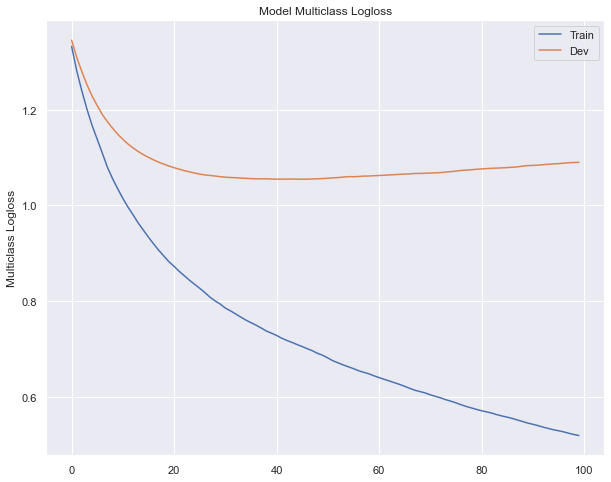


Number of times a feature is used to split the data across all trees:


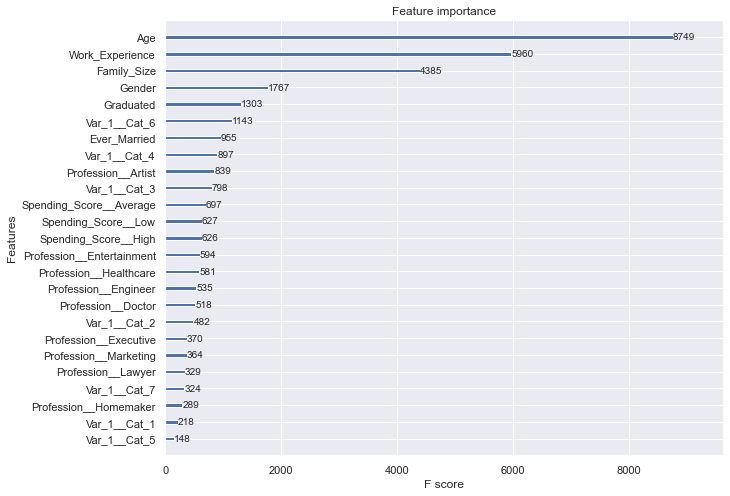


Number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits:


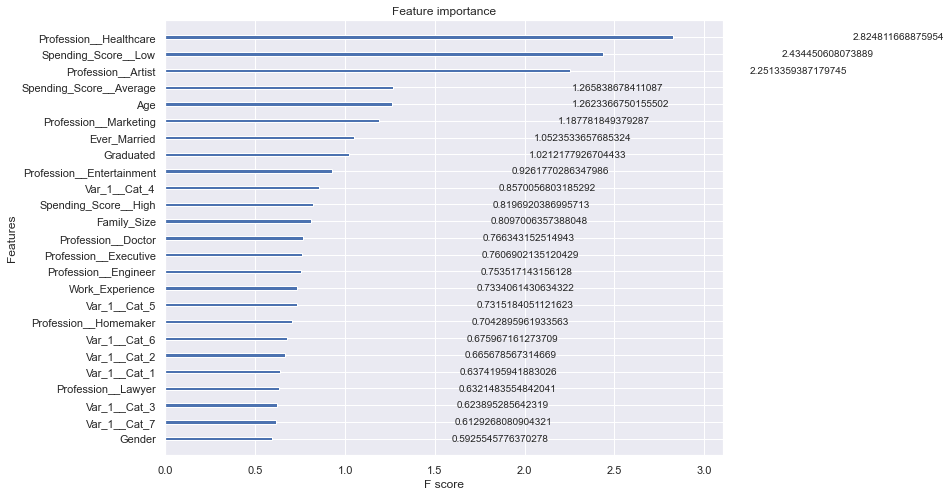


The average training loss reduction gained when using a feature for splitting:


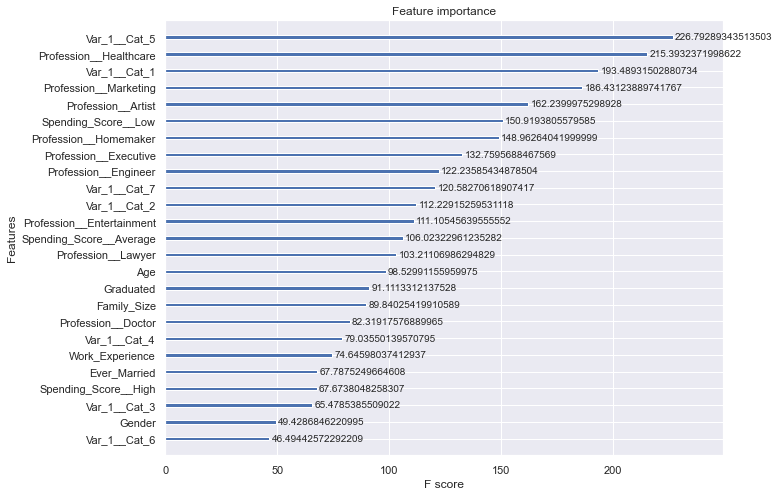

In [258]:
# baseline model implementations & training
model = model_pipeline(df_features=xgb_train, df_y=y, n_split=2)

In [236]:
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.7,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, nthread=8, num_class=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=999,
              reg_alpha=0.1, reg_lambda=0, scale_pos_weight=None, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)


Visualize the trees


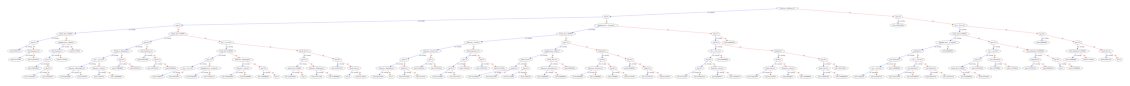

In [209]:
print('\nVisualize the trees')
plt.rcParams["figure.figsize"] = (20, 10)
plot_tree(model)
plt.show()


**Observation:**

As a result, after training and fine-tunings for the model, we are able to achieve the multi-class classification accuracy at ~87%. Our f1-score is around 0.53. The results shown that we have somewhat equal amount of false positive and false negative in each segments. Definitely, this is not optimal. we can improve further from the error part and achieve a better f score for the classifer. 

However, as a baseline, this alreday demonstrated model's ability for classifying each customers to different segments. It is the right direction and can be improved further by either request larger datset to be trained, or include and extract more features (feature engineering).

In addition, given that this baseline provided us a much more clearer way to understand the feature's importance. We can levearage a more state-of-the-art deep learing framework to perform a pre-trained on categorical features and that may improved further in terms of the classfication's accuracy.


### 3. Fine-tunnings
This cross validation gridsearch procedure was cross performed and evaluted with model pipelines during trainings. 

In [ ]:
# def optimization(param_test, X_train, y_train):
#     '''run GridSearchCV to identify optimal parameters'''
    
#     # initial our raw baseline model
#     gsearch = GridSearchCV(estimator=XGBClassifier(
#                                         objective='multi:softprob',
#                                         num_class=4,
#                                         learning_rate=0.1,
#                                         max_depth=8,
#                                         subsample=0.9,
#                                         colsample_bylevel=0.7,
#                                         colsample_bytree=0.8,
#                                         reg_alpha = 0.1,
#                                         reg_lambda=0,
#                                         nthread=8,
#                                         random_state=999),\
#                            param_grid = param_test,\
#                            scoring='mlogloss',\
#                            n_jobs=4,iid=False
#                           )
    
#     # fit gridsearch
#     gsearch.fit(X_train, y_train) 
    
#     # obtain the best paramter
#     optimal_param = gsearch.best_params_

#     return optimal_param



# # max_depth

# param_test= {
#     'max_depth':range(4,10,2)
# }

# optimal_params = optimization(param_test, xgb_train, y_train)

# print('best max_depth:', optimal_params)


# # reg_alpha

# param_test= {
#     'reg_alpha':[i/10.0 for i in range(0,5)]
# }

# optimal_params = optimization(param_test, xgb_train, y_train)

# print('best reg_alpha:', optimal_params)


# # eta

# param_test= {
#     'eta':[i/10.0 for i in range(1,5)]
# }

# optimal_params = optimization(param_test, xgb_train, y_train)

# print('best eta:', optimal_params)


# # subsample

# param_test= {
#     'subsample':[i/10.0 for i in range(6,10)]
# }

# optimal_params = optimization(param_test, xgb_train, y_train)

# print('best subsample:', optimal_params)

# # colsample_bytree

# param_test= {
#     'colsample_bytree':[i/10.0 for i in range(6,10)]
# }

# optimal_params = optimization(param_test, xgb_train, y_train)

# print('best colsample_bytree:', optimal_params)


# H - Prediction<a class="anchor" id="8"></a>

Here we are come to solve our objective - predictions for the segments on test data (new customers).

**Predictionon test dataset. Noticed that we also combined the customer ID in the files, make the predictions, and map the predicted encoded labels back to the original letter labels.**

In [259]:
# prediction by the model applied in the test dataset
predicted_value = model.predict(xgb_test)

# create a data frame with mapping ID 
prediction_key = modeling[obs_train:]['ID']
prediction = pd.DataFrame(prediction_key, columns=['ID']).reset_index()
prediction['Predicted_Segmentation'] = predicted_value
# mapping to lookup value
# inverse lookup
target_encoding_lookup_ivd = {v: k for k, v in target_encoding_lookup.items()}
prediction['Predicted_Segmentation'] = prediction['Predicted_Segmentation']\
                                        .apply(lambda x: target_encoding_lookup_ivd[x])

# check and show top 10 rows for the prediction files
print(prediction.shape)
prediction.head(15)


(2627, 3)


,index,ID,Predicted_Segmentation
0,8068,458989,A
1,8069,458994,C
2,8070,458996,B
3,8071,459000,C
4,8072,459001,D
5,8073,459003,C
6,8074,459005,B
7,8075,459008,C
8,8076,459013,C
9,8077,459014,D


In [260]:
# check if any nan values
prediction.isnull().sum()


index                     0
ID                        0
Predicted_Segmentation    0
dtype: int64

  Predicted_Segmentation  count
0                      A    603
1                      B    559
2                      C    654
3                      D    811


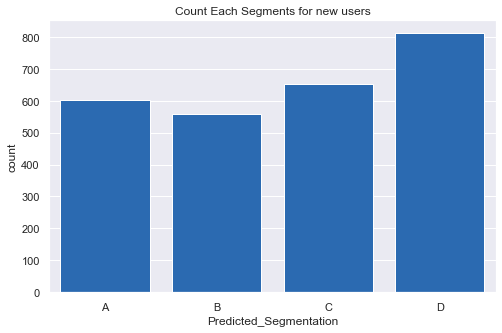

In [261]:
# Visualize the predicted segments
tmp = prediction.copy()
tmp = sqldf("""
select
    Predicted_Segmentation,
    count(Predicted_Segmentation) as count
from tmp
group by 1

""")
print(tmp)
sns.set(rc={'figure.figsize':(8, 5)})
sns.barplot(x='Predicted_Segmentation' , y='count', data=tmp, color='#1569C7').set_title('Count Each Segments for new users')
del tmp



Indeed, in terms of the overall trend for the segmentations, D appears to be the largest group segmentations. This is more or less in lines with our exisiting label data (train) as well as our exploratory data analysis that segment D looks to be much younger customers, smaller family, as well as those who are unmarried.

In [263]:
# save a copy of prediction results 
# prediction.to_csv('./data/prediction_segments.csv', index=False)

# I - Conclusions

1. To solve this probelms, we first understand our data in general, and understand the objective is to classify customer profiles into 4 different segment labels, which translate the problem into a suprverised learing multi-classificaiton problems. 

2. We assessed the given features and noticed that many features in the dataset are categorical data, and it is already in its granular sense. Therefore, before conducting EDA and Modeling, we should impute the missing data by more a robust algorithm in stead of dropping or simple filling in. My data imputing strategy was then based on a robust statitstical distributions and model-based imputations under the hood of MICE methods.

3. Followed by the data processing and imputing is the EDA, where we got better understanding of the customers profile and distributions by each segments. And then we frame our methodoly and propose a baseline model with xgbosst ensemble learing methods. This is a relatively strong base line because of ensemble, generalizable, and adpatble.

4. Referenced with our baseline's classification errors and performance report in training procedure. We concluded that the baseline is in the right direction for this types of probelms. However, there are many room to improve regarding the prcision and reacall in each of the segmented groups. We also conclude if we can have more data for training, or more features to be included, that would be beneficial. Furthermore, we can better handel the categorical signals by more advanced deep learing methods as a pre-train model in attempts to increase signals thereby increasing the multi-classification accuracy in the problem.


# J - Future Study & Directions<a class="anchor" id="10"></a>

1. More feature engineering. Gather more customer's profile data, such as detailed demogrpahic and financial income, social media data, product-specific user data, as well as industry data. That way we would extract more relevant and learnable features for this classification problems.

2. By introducting the ML model, we classify the customers into different segments. The next step would be beneficial regarding judging the model performance is to launch a pilot study from a customer surveys, or conduct randomized trial experimentations on the product side, in which we are able to further understand whether the segemnts makses sense. This practice can improve our understanding of the features as well as serve as a starting point for enhanced feature engineering and model improvements.

3. To extent the baseline methods, we should conduct more literature reviews, brainstorm, and research novel ideas in terms of customized our classificaiton modeling mehtodlogy. Since every organization has different proudct behaviors and customer behaviors, certainly we can gather more information and strengthen model's generalization ability. 

4. Understand better for the org and products, as well as how the behaviors are shifted over time is important. 


# ------The End ------
- Ken Tsung-Chin Han
- 2/12/2021
